In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15830492440666651422
]


/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True


In [3]:
import os
import pandas as pd

import tensorflow as tf
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

from Eve import Eve

%matplotlib inline

/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)
Using TensorFlow backend.


___

In [4]:
train_dir = 'data/Reinhard'

In [5]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/training 0
data/training/Invasive 7
data/training/Normal 7
data/training/InSitu 7
data/training/Benign 7


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.25)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


#target_size: Tuple of integers (height, width), default: (256, 256). 
#The dimensions to which all images found will be resized.
target_size = (256, 256)
#target_size = (height, width)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        batch_size=32,
        subset="training",
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        batch_size=32,
        subset = "validation",
        shuffle = True)

Found 24 images belonging to 4 classes.
Found 4 images belonging to 4 classes.


In [7]:
## Intilizing variables
output_classes = 4
batch_size = 32 
epochs = 30

sgd_opt = SGD(lr=1E-2, decay=1E-4, momentum=0.9, nesterov=True)
adam_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1E-4)
eve_opt = Eve(lr=1E-4, decay=1E-4, beta_1=0.9, beta_2=0.999, beta_3=0.999, small_k=0.1, big_K=10, epsilon=1e-08)

resume_model = False
xception_weights = 'pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
model = Sequential()

model.add(Xception(weights = xception_weights , include_top=False,pooling = 'avg'))

model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

model.compile(loss = 'categorical_crossentropy',
              optimizer = eve_opt,
              metrics = ['accuracy'])

In [9]:
for i, layer in enumerate(model.layers):
    print('Layer: ',i+1,' Name: ', layer.name)

Layer:  1  Name:  xception
Layer:  2  Name:  dense_1


In [10]:
num_train_samples= len(train_generator.filenames)
num_train_samples

24

In [11]:
num_val_samples= len(validation_generator.filenames)
num_val_samples

4

In [12]:
history = model.fit_generator(train_generator,
        steps_per_epoch =int(np.ceil(num_train_samples * 1.0 / batch_size)),
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps=int(np.ceil(num_val_samples * 1.0 / batch_size)))

Epoch 1/30
1/1 [==============================] - 45s 45s/step - loss: 1.3518 - acc: 0.2917 - val_loss: 1.2658 - val_acc: 0.7500
Epoch 2/30
1/1 [==============================] - 31s 31s/step - loss: 1.2207 - acc: 0.6250 - val_loss: 1.0885 - val_acc: 0.7500
Epoch 3/30
1/1 [==============================] - 38s 38s/step - loss: 1.0371 - acc: 0.9167 - val_loss: 1.1174 - val_acc: 0.5000
Epoch 4/30
1/1 [==============================] - 36s 36s/step - loss: 0.9079 - acc: 1.0000 - val_loss: 0.7907 - val_acc: 1.0000
Epoch 5/30
1/1 [==============================] - 32s 32s/step - loss: 0.7629 - acc: 1.0000 - val_loss: 0.7510 - val_acc: 1.0000
Epoch 6/30
1/1 [==============================] - 31s 31s/step - loss: 0.6554 - acc: 1.0000 - val_loss: 0.8090 - val_acc: 1.0000
Epoch 7/30
1/1 [==============================] - 30s 30s/step - loss: 0.5332 - acc: 1.0000 - val_loss: 0.5642 - val_acc: 1.0000
Epoch 8/30
1/1 [==============================] - 31s 31s/step - loss: 0.4407 - acc: 1.0000 - val

In [13]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [14]:
history.history["val_loss"]

[1.2657561302185059,
 1.0885014533996582,
 1.1174468994140625,
 0.7906718254089355,
 0.7510188817977905,
 0.8089967370033264,
 0.5642397999763489,
 0.569812536239624,
 0.36774343252182007,
 0.4366897940635681,
 0.29149115085601807,
 0.22504985332489014,
 0.20209740102291107,
 0.17426064610481262,
 0.2020428478717804,
 0.1343810111284256,
 0.06917959451675415,
 0.049631837755441666,
 0.1073380708694458,
 0.04221010208129883,
 0.02849700301885605,
 0.0672990083694458,
 0.020371178165078163,
 0.03484993427991867,
 0.03285457193851471,
 0.08245985209941864,
 0.019341347739100456,
 0.020211344584822655,
 0.018279265612363815,
 0.015178289264440536]

In [15]:
history.history["val_acc"]

[0.75,
 0.75,
 0.5,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [16]:
history.history["loss"]

[1.351829171180725,
 1.2206578254699707,
 1.0371190309524536,
 0.9078905582427979,
 0.762850284576416,
 0.6553599834442139,
 0.5331523418426514,
 0.44067224860191345,
 0.3626965284347534,
 0.2825755774974823,
 0.2192852646112442,
 0.18550516664981842,
 0.14610612392425537,
 0.13634724915027618,
 0.10588401556015015,
 0.0728098526597023,
 0.05208324268460274,
 0.04547156020998955,
 0.03783595189452171,
 0.03069431520998478,
 0.025347823277115822,
 0.018130574375391006,
 0.017136631533503532,
 0.012855560518801212,
 0.014246697537600994,
 0.009364291094243526,
 0.008303199894726276,
 0.008153497241437435,
 0.0077039399184286594,
 0.00807343889027834]

In [17]:
history.history["acc"]

[0.2916666567325592,
 0.625,
 0.9166666865348816,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [18]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.024556644596159458
Test Accuracy:  1.0


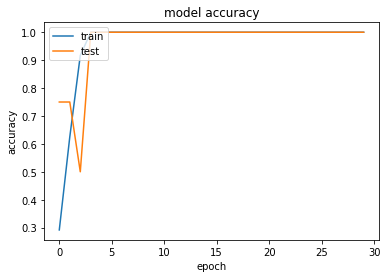

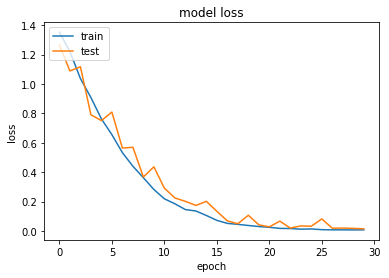

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

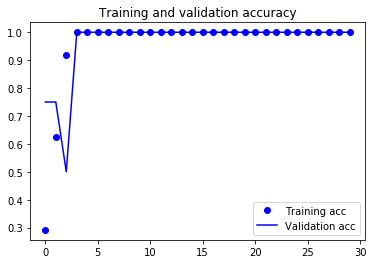

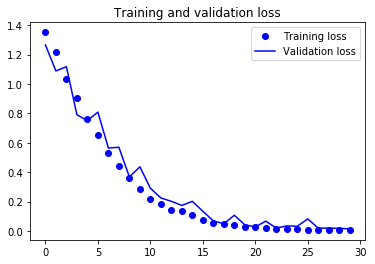

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


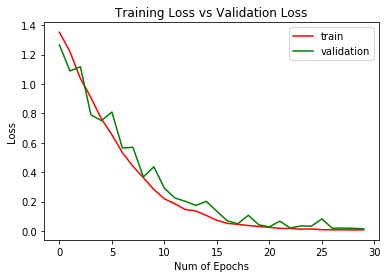

In [21]:
import numpy as np
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [22]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [23]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

1/0 [================================================================================================================================================================================================================================================] - 3s 3s/step
No of errors = 3/4


Confusion Matrix
[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]]


/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


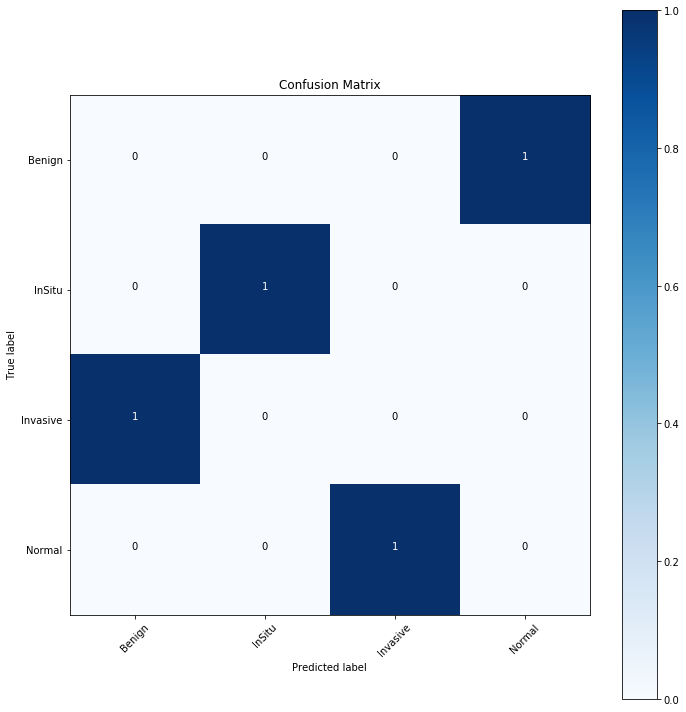

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [25]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

In [26]:
predict_and_report(train_generator, model)

Accuracy: 0.5
Area Under the Receiver Operating Characteristic Curve: 0.33333333333333337
             precision    recall  f1-score   support

          0       1.00      0.33      0.50        18
          1       1.00      1.00      1.00         6
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0

avg / total       1.00      0.50      0.62        24



/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [27]:
predict_and_report(validation_generator, model)

Accuracy: 0.5
Area Under the Receiver Operating Characteristic Curve: 0.33333333333333337
             precision    recall  f1-score   support

          0       1.00      0.33      0.50         3
          1       1.00      1.00      1.00         1
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0

avg / total       1.00      0.50      0.62         4



/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [28]:
best_train_acc = max(history.history['acc'])
best_train_acc

1.0

In [29]:
last_train_acc = history.history['acc'][-1]
last_train_acc

1.0

In [30]:
model.save('models/1.Xception-Eve-Model.h5')
model.save_weights('models/1.Xception-Eve-Weights.h5')